### FastAI Transfer Learning on Stanford Cars Dataset with 1Cycle Learning Rate Policy

In [1]:
import os
import shutil

In [2]:
%%capture
import random
import numpy as np
import pandas as pd
import numpy.random as rng
import matplotlib.pyplot as plt

In [3]:
import imageio

This part is taking the data which has already been organized from Sylvain's code:

In [4]:
if os.path.exists('./Adam-experiments'):
    os.chdir('./Adam-experiments')
if os.path.exists('./data/cars'):
    os.chdir('./data/cars/')

In [5]:
!ls

annots.csv  car_ims  car_ims.tgz  cars_annos.mat  models  tmp  train  valid


In [6]:
import scipy.io
annos = scipy.io.loadmat('cars_annos.mat')

In [7]:
annos.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations', 'class_names'])

In [8]:
classes = pd.DataFrame(annos['class_names'])

In [9]:
classes.get(0).values[0][0]

'AM General Hummer SUV 2000'

In [10]:
annotations = np.array(annos['annotations'])

In [11]:
len(annotations[0])

16185

In [12]:
# Rubric: annotations[0] is the matrix of data
# [0][i] is the ith row of the matrix
# [0][i][j] is the (i,j)th element of the matrix
# j = 0 is fname, 1 is bboxx1, 2 is bboxy1, 
# 3 is bboxx2, 4 is bboxy2, 5 is class, 6 is bool(test)
# to get the fname, append [0]
# to get all others, append [0][0]

In [13]:
from collections import defaultdict

#classes are minus 1 to convert MATLAB indexing

train_fnames = [annotations[0][i][0][0] for i in range(len(annotations[0]))
                if annotations[0][i][6][0][0] == 0]
train_classes = [annotations[0][ii][5][0][0] - 1 for ii in range(len(annotations[0]))
                if annotations[0][ii][6][0][0] == 0]

test_fnames = [annotations[0][i][0][0] for i in range(len(annotations[0]))
                if annotations[0][i][6][0][0] == 1]
test_classes = [annotations[0][ii][5][0][0] - 1 for ii in range(len(annotations[0]))
                if annotations[0][ii][6][0][0] == 1]

train_data = zip(train_classes, train_fnames)
test_data = zip(test_classes, test_fnames)

train_dict = defaultdict(list)
test_dict = defaultdict(list)

for tr_cl, tr_fname in train_data:
    train_dict[tr_cl].append(tr_fname)
    
for ts_cl, ts_fname in test_data:
    test_dict[ts_cl].append(ts_fname)


['car_ims/015761.jpg', 'car_ims/015762.jpg', 'car_ims/015763.jpg', 'car_ims/015764.jpg']


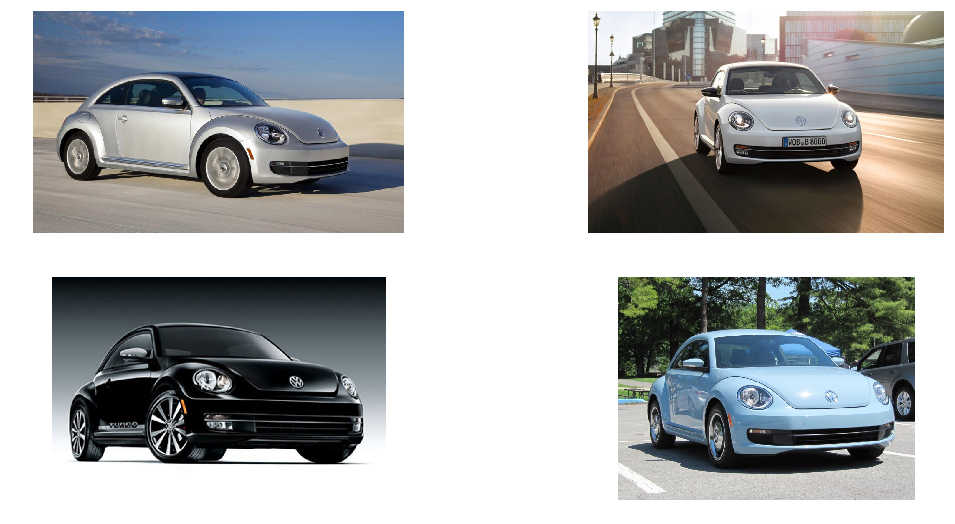

Volkswagen Beetle Hatchback 2012


In [14]:
# Look at several images from the training set
rand_cl = rng.choice(196)
print(train_dict[rand_cl][0:4])

fig=plt.figure(figsize=(18, 9))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = imageio.imread(train_dict[rand_cl][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show() 

print(classes.get(rand_cl).values[0][0])

['car_ims/015804.jpg', 'car_ims/015805.jpg', 'car_ims/015806.jpg', 'car_ims/015807.jpg']


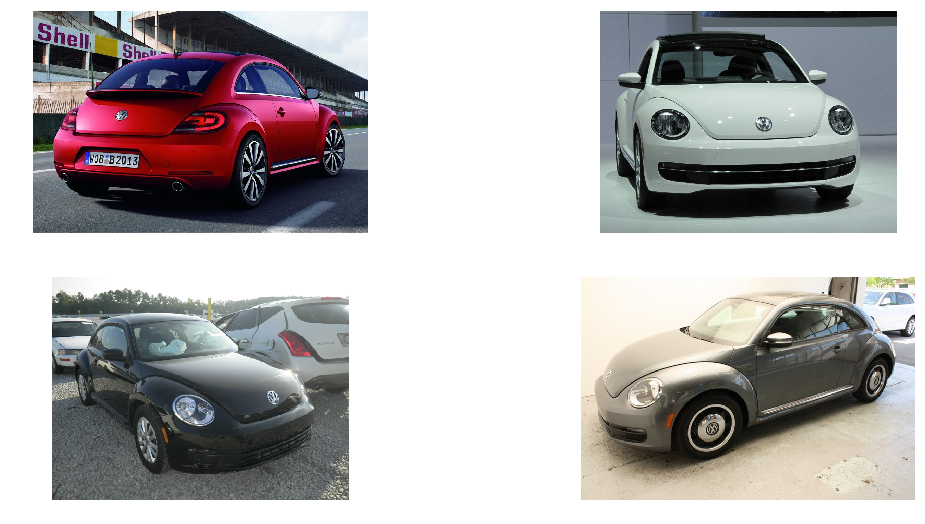

Volkswagen Beetle Hatchback 2012


In [15]:
# Look at several images from the testing set
print(test_dict[rand_cl][0:4])

fig=plt.figure(figsize=(18, 9))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = imageio.imread(test_dict[rand_cl][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

print(classes.get(rand_cl).values[0][0])

In [16]:
# Make train and validation folders for fastai dataloader

if os.path.exists('./train'):
    shutil.rmtree('./train')
if os.path.exists('./valid'):
    shutil.rmtree('./valid')
    
!mkdir ./train
!mkdir ./valid

# Populate the class folders with images
for cl in train_dict.keys():
    train_folder = './train/' + str(cl) + "/"
    valid_folder = './valid/' + str(cl) + "/"
    if not os.path.exists(train_folder):
        os.mkdir(train_folder)
    if not os.path.exists(valid_folder):
        os.mkdir(valid_folder)
        
    for tr_img in train_dict[cl]:
        shutil.copy(tr_img, train_folder)
    for val_img in test_dict[cl]:
        shutil.copy(val_img, valid_folder)       

In [17]:
%%capture

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
#import skimage

In [18]:
def get_data(sz, bs=128, arch=resnet50, aug_tfms=transforms_side_on,
             max_zoom=1.05, num_workers=8):
    tfms = tfms_from_model(arch, sz, 
                       aug_tfms=aug_tfms, 
                       max_zoom=max_zoom)
    data = ImageClassifierData.from_paths('', bs=bs, tfms=tfms,
                                          num_workers=num_workers)
    return data

arch = resnet50
sz = 240
# Side on tranforms but increased a bit
aug_tfms = [RandomRotateZoom(deg=20, zoom=1.25, stretch=0.1)]
aug_tfms += [AddPadding(pad=20, mode=cv2.BORDER_CONSTANT)]
aug_tfms += [RandomLighting(0.1, 0.1)]
aug_tfms += [Cutout(n_holes=5, length=14, tfm_y=TfmType.NO)]
aug_tfms += [RandomFlip()]
#aug_tfms += [GoogleNetResize(targ_sz=sz)]

# Augmentations did next to nothing, so I loaded data with default tfms
data = get_data(sz, bs=128)

In [19]:
# Without precompute set to False, this gives bad results.
learn = ConvLearner.pretrained(arch, data, ps=[0.5,0.5], precompute=False)

Here I modified the default FastAI pipeline by enhancing the augmentations and increasing the dropout on the penultimate layer. Although I haven't extensively tested yet, the augmentations didn't seem to have much effect on overfitting compared to the dropout.

Precomputation seems to just make it much harder to train the entire network afterward, so any time saved on precomputation is not worth it.

In [20]:
learn.opt_fn = optim.Adam

In [21]:
learn.summary

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), 

In [22]:
learn.freeze()

In [23]:
#lrf=learn.lr_find(wds = 1e-2, use_wd_sched=True, start_lr=1e-05, end_lr=10)

In [24]:
#learn.sched.plot(n_skip=0,n_skip_end=3)

This code will barely fit in a 16 GB P100 GPU. So I use empty_cache() in order to maximize the memory utilization.

In addition, running the learning rate finder takes up memory space so when testing a full model it is probably best to run the finders and then run the model all at once separately. 

In [25]:
#Use this to free more GPU memory after running training
torch.cuda.empty_cache()

In [26]:
result, ep_vals = learn.fit(3e-2, 1, cycle_len=10, use_clr_beta=(10, 10), wds=1e-3, use_wd_sched=True, get_ep_vals=True)

epoch      trn_loss   val_loss   accuracy                  
    0      4.000707   3.009049   0.266509  
    1      3.29976    2.713401   0.315881                  
    2      3.017603   2.52114    0.354434                  
    3      2.930649   2.625037   0.32869                   
    4      2.93805    2.501883   0.361025                  
    5      2.763854   2.29954    0.408407                  
    6      2.466543   2.136147   0.442731                  
    7      2.161388   1.920315   0.489491                  
    8      1.87205    1.798246   0.524686                  
    9      1.641066   1.748839   0.539236                  



I trained the head only until the training loss was about equal to the validation loss in order to avoid too much overfitting.

In [27]:
learn.unfreeze()
torch.cuda.empty_cache()

In [28]:
#lrf=learn.lr_find(wds = 3e-2, use_wd_sched=True, start_lr=1e-06, end_lr=10)
#learn.sched.plot(n_skip=0,n_skip_end=3)

In [29]:
torch.cuda.empty_cache()

In [30]:
lr2=1e-2

In [31]:
# This particular dataset seems to train better with
# somewhat higher learning rates in the lower layers,
# possibly because the Imagenet weights don't generalize
# to this dataset very well.
lrs = np.array([lr2/30,lr2/3,lr2])

In [32]:
result2, ep_vals2 = learn.fit(lrs, 1, cycle_len=20, use_clr_beta=(10, 10), wds=1e-3, use_wd_sched=True)

epoch      trn_loss   val_loss   accuracy                  
    0      2.720652   2.818544   0.310409  
    1      2.02267    1.739196   0.515732                  
    2      1.709091   2.053381   0.451809                  
    3      1.533756   1.621533   0.54732                   
    4      1.405369   1.746711   0.532894                  
    5      1.282408   1.81473    0.540107                  
    6      1.20869    1.384818   0.609501                  
    7      1.152082   1.705288   0.550553                  
    8      1.164767   1.697633   0.551673                  
    9      1.104639   1.578088   0.578908                  
    10     1.072484   2.604278   0.430295                  
    11     1.127829   2.474403   0.432036                  
    12     1.14907    1.546323   0.585126                  
    13     1.152233   1.806436   0.542719                  
    14     1.052618   1.42958    0.612983                  
    15     0.893922   1.651538   0.578286               

In [33]:
torch.cuda.empty_cache()

In [34]:
log_preds, y = learn.TTA()

In [89]:
probs = np.exp(log_preds)

In [90]:
avg_TTA = np.mean(probs, axis = 0)

In [91]:
preds = np.argmax(avg_TTA,axis=1)
pred_probs = np.max(avg_TTA,axis=1)
targs = y

In [92]:
TTA_acc = (preds==targs).mean()
print("Final accuracy: " + str(TTA_acc*100)[:5] + "%")

Final accuracy: 88.91%


TTA improved the accuracy very slightly, by about 1%.

In [93]:
#plt.hist(preds, bins=np.arange(196))

The worst predicted class is found by taking the mode of the targets that were missed:

In [94]:
from scipy.stats import mode
print(*mode(y[np.where(preds != targs)]).mode)

164


In [95]:
print(classes.get(164).values[0][0])

Mercedes-Benz S-Class Sedan 2012


In [111]:
targs

array([  0,   0,   0, ..., 195, 195, 195])

In [96]:
wrongs = np.where(preds != targs)[0]
wrg_per_cl = np.histogram(wrongs,bins=cl_bins)[0]

Create bins so that the $n^{th}$ wrongly classified test image can be placed into a class using np.digitize or np.histogram:

In [100]:
cl_bins = np.insert(np.cumsum(list(map(len, test_dict.values()))),0,0)

In [101]:
# Find the top 10 worst classes predicted
worst_ten = list(np.argsort(wrg_per_cl)[-10:])
print(worst_ten)
for worst in worst_ten:
    print(classes.get(worst).values[0][0] + ": " +
          str(wrg_per_cl[worst]))

[90, 168, 69, 92, 146, 132, 112, 36, 91, 164]
Dodge Dakota Club Cab 2007: 11
Nissan NV Passenger Van 2012: 11
Chevrolet Silverado 1500 Classic Extended Cab 2007: 12
Dodge Challenger SRT8 2011: 12
Jeep Liberty SUV 2012: 13
Hyundai Veracruz SUV 2012: 13
Ford F-150 Regular Cab 2012: 13
BMW X3 SUV 2012: 16
Dodge Magnum Wagon 2008: 17
Mercedes-Benz S-Class Sedan 2012: 19


In [163]:
cl_matcher = np.digitize(wrongs, cl_bins)-1

In [151]:
# Create a dictionary of the wrongly predicted images
cl_matcher = np.digitize(wrongs, cl_bins)-1
wrg_dict = defaultdict(list)
for i, wrg in enumerate(wrongs):
    wrg_cl = cl_matcher[i]
    wrg_idx = wrg - cl_bins[wrg_cl]
    wrg_fname = test_dict[wrg_cl][wrg_idx]
    wrg_dict[wrg_cl].append(wrg_fname)

### Worst Performing Classes:
This section plots images of the 10 worst performing classes (classes with the highest error rate).
On the left column is a random wrongly classified image from each of the 10 classes, and on the right is (a random test image from) the incorrect class that the model predicted. 

In [475]:
missed_imgs = np.where(preds!=targs)[0]
missed_targs = targs[missed_imgs]

In [439]:
num_missed, bins = np.histogram(missed_targs, bins=np.arange(197))
bins = bins[:-1].copy()

In [449]:
bottom_ten = np.argsort(num_missed)[-10:]

array([ 23, 167, 145, 156, 120, 110,  79,  90,  35, 164])

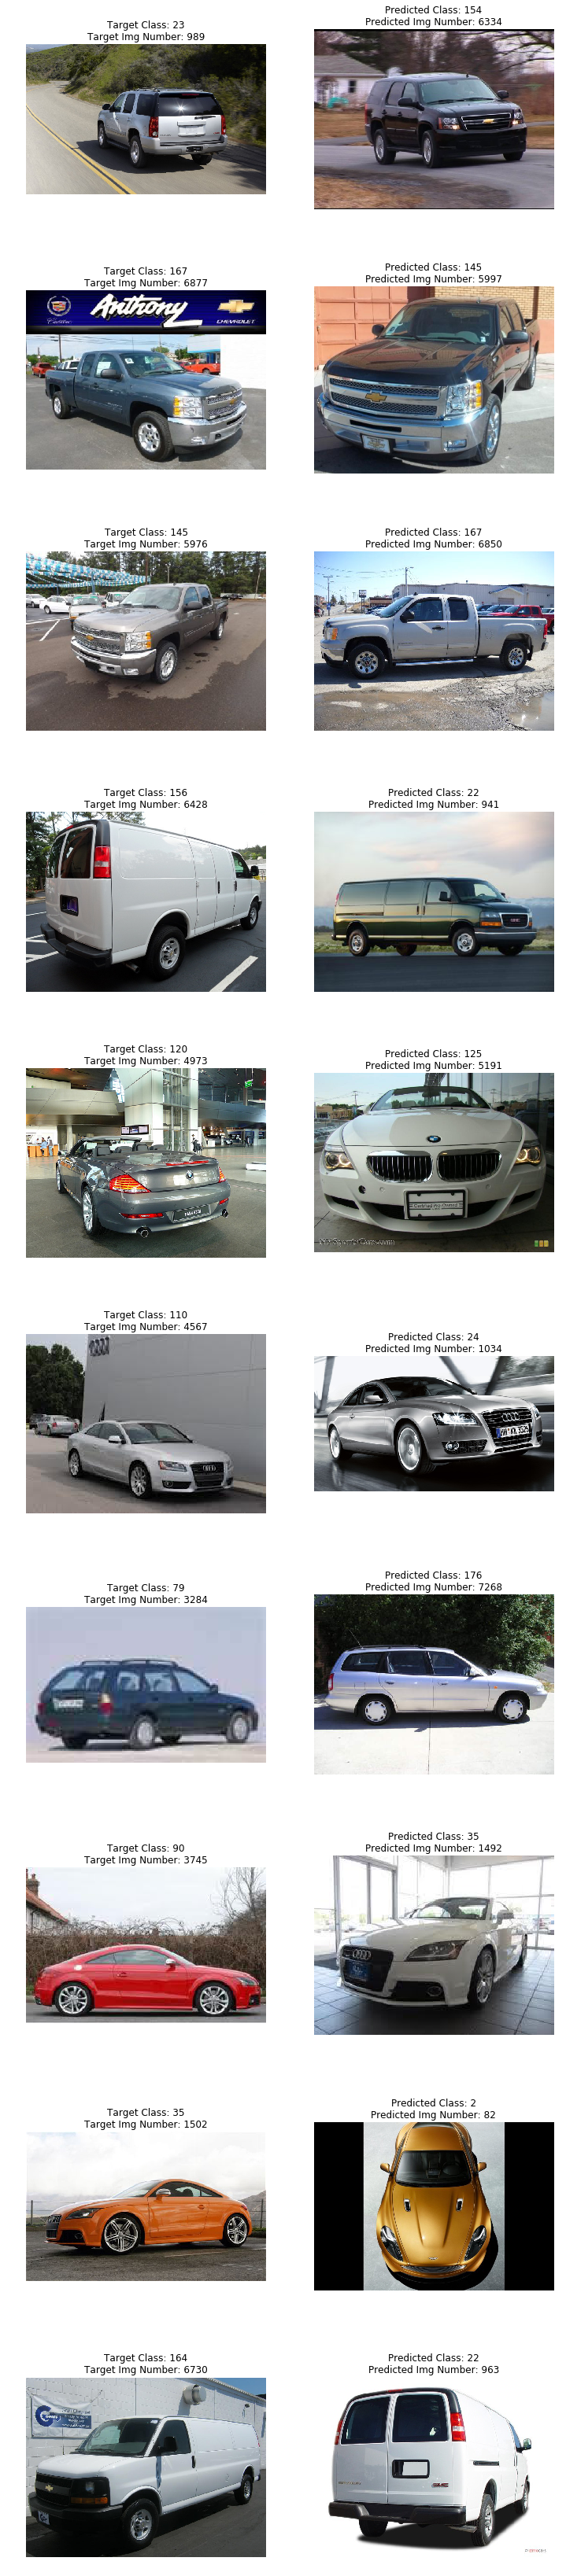

In [477]:
fig = plt.figure(figsize=(12,60))
f = learn.data.val_ds

for i, bot in enumerate(bottom_ten):
    idxs = np.where(missed_targs==bot)[0]
    idx = rng.choice(idxs)
    img_num = missed_imgs[idx]
    targ_fname = f.fnames[img_num]
    
    act_img = imageio.imread(targ_fname)
    ax = fig.add_subplot(10, 2, 2*i+1)
    ax.set_title("Target Class: " + str(bot) +
                "\nTarget Img Number: " + str(img_num))
    plt.imshow(act_img)
    plt.axis('off')
    
    # just show a random in the wrongly predicted class for illustration
    pred_cl = preds[img_num]
    pred_nums = np.where(targs==pred_cl)[0]
    pred_num = rng.choice(pred_nums)
    pred_fname = f.fnames[pred_num]
    #miss_conf = pred_probs[img_num]
    #corr_conf = avg_TTA[img_num][targ_cl]    
    
    pred_img = imageio.imread(pred_fname)
    ax2 = fig.add_subplot(10, 2, 2*i+2)
    ax2.set_title("Predicted Class: " + str(pred_cl) +
                 "\nPredicted Img Number: " + str(pred_num))
    plt.imshow(pred_img)
    plt.axis('off')

plt.show()  

It seems that most of the images that the classifier misses are actually very similar, sometimes even difficult for me as a human to detect. This means that it is probably a good classifier.

Re-running the plot section several times will show more failure examples on the right column (left column is always the correct class).